# **birdify**
## Classification of bird songs based on audio recordings

## 1. Dataset

All audio data used in this project come from **Bird songs from Europe (xeno-canto)**
collection built from a xeno-canto API query and uploaded on Kaggle by Francisco de Abreu e Lima.

In theory, the recordings contain only male songs from 50 bird species, but
in reality they may contain i.e. mixtures of calls and songs from both male and female birds from the same or different species.
This can certainly affect the classification results.

### First look at class distribution
Though the dataset contains 43 audio files for each species of minimum 30s, the differences in lengths are significant. A better understanding of class distribution will be possible after signal/noise separation step. A this moment the content of each sample is unknown and could possibly contain background noise in the larger part.

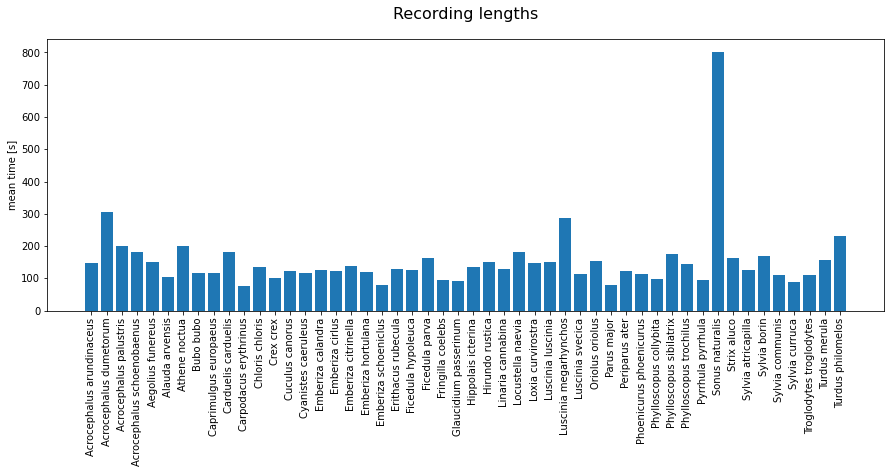

In [33]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

dataset = pd.read_csv(r'dataset.csv')

def timedeltas(x):
    t = datetime.strptime(x, '%M:%S').time()
    return timedelta(minutes=t.minute, seconds=t.second)

dataset['duration'] = dataset['Length'].apply(lambda x: timedeltas(x).total_seconds())

plotting = dataset.groupby(['Name'])['duration'].mean()
plt.figure(figsize=(15,5))
plt.bar(x=plotting.index, height=plotting.values)
plt.xticks(rotation = 90)
plt.xlabel(None)
plt.ylabel('mean time [s]')
plt.title('Recording lengths', fontdict={'size':16}, y=1.05)
plt.show()

## 2. Preprocessing

To unify sample rate, as a first step, all recordings are resampled to 22050Hz.

_Method performing resampling for whole directory:_
```python
from soundmatrix.processing.extraction import resample_dir
```

### SIGNAL / NOISE separation

Each recording's length may vary from 30 second up to 30 minutes. Bird vocalizations are, to say the least,
not continuous throughout each file. In fact, splitting raw data into chunks would end up
with many samples containing solely background noise.

In that case it's necessary to differentiate _signal_ and _noise_. One possible strategy
presented in [3,4] is based on _**median cropping**_ of spectrogram, followed by applying
binary erosion and dilation filter.
This approach creates a binary indicator vector that, when scaled to the length of the recording,
can serve as a filter mask.

In [159]:
from pydub import AudioSegment
import numpy as np
from scipy.signal import stft
from scipy.ndimage import binary_erosion, generate_binary_structure, grey_erosion, grey_dilation, binary_dilation, interpolation
from numba import jit

song = AudioSegment.from_mp3(r'./resampled/Acrocephalus-arundinaceus-363793.mp3')
samples = song.get_array_of_samples()
samples = np.array(samples, dtype=float)

window_size: int = 512
overlapping = .75
bot_bins_out: int = 4
top_bins_out: int = 24

filter_size = (4,4)
median_multi = 3
vector_filter = 4
n_dilation = 3

# fft calculate
window_size: int = 512
f, t, Zxx = stft(samples, nperseg=window_size, nfft=512, window='hann', noverlap=int(window_size*overlapping), fs=22050)

# MinMax scaling
Zxx_abs = np.abs(Zxx)
Zxx = (Zxx_abs - Zxx_abs.min())/(Zxx_abs.max() - Zxx_abs.min())

Zxx = Zxx[bot_bins_out:-top_bins_out,:]
f = f[bot_bins_out:-top_bins_out]

# median clipping
@jit(nopython=True)
def median_clipping_kernel(matrix, row_median, col_median, multi):
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if (matrix[i, j] > multi*row_median[i])&(matrix[i, j] > multi*col_median[j]):
                matrix[i,j] = 1
            else:
                matrix[i,j] = 0
    return matrix

def median_clipping(matrix, multi):
    r_median = np.median(matrix, axis=1)
    c_median = np.median(matrix, axis=0)
    matrix = median_clipping_kernel(matrix, r_median, c_median, multi)
    return matrix

def binary_h_vector(matrix):
    bin_vec = np.zeros_like(matrix[0,:], dtype=int)
    for j in range(matrix.shape[1]):
        if any(matrix[:,j]==1):
            bin_vec[j] = 1
        else:
            bin_vec[j] = 0
    return bin_vec

Zxx_mod = median_clipping(Zxx, median_multi)
bin_vector1 = binary_h_vector(Zxx_mod)
Zxx_mod = grey_erosion(Zxx_mod, size=filter_size)
bin_vector2 = binary_h_vector(Zxx_mod)

for n in range(n_dilation):
    bin_vector3 = grey_dilation(bin_vector2, size=vector_filter)

masking = interpolation.zoom(bin_vector3, zoom=len(samples)/len(bin_vector3))
masking = np.ma.make_mask(masking)

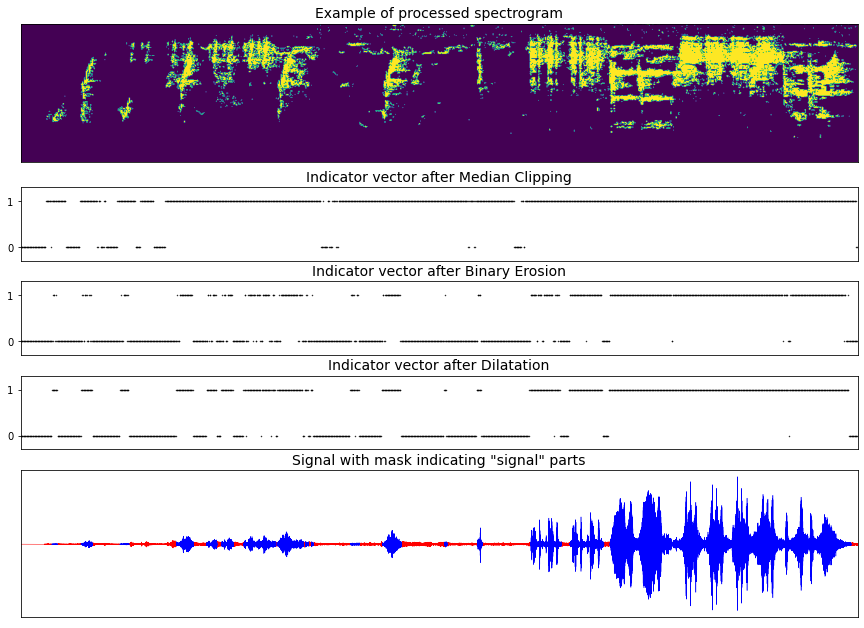

In [187]:
fig, axs = plt.subplots(5, figsize=(15,11), gridspec_kw={'hspace': .2, 'height_ratios': [2, 1,1,1,2]})
# fig.suptitle('Indicator vector', fontsize=20)
sh_len = 691*2
axs[0].set_title('Example of processed spectrogram', fontsize=14)
axs[0].imshow(Zxx[:,:sh_len])
axs[0].set_yticks([])
axs[0].set_xticks([])
axs[1].scatter(np.arange(0,sh_len), bin_vector1[:sh_len], s=.2, c='k')
axs[1].set_yticks([0,1])
axs[1].set_xticks([])
axs[1].set_ylim(-.3,1.3)
axs[1].set_xlim(0,sh_len)
axs[1].set_title('Indicator vector after Median Clipping', fontsize=14)
axs[2].scatter(np.arange(0,sh_len), bin_vector2[:sh_len], s=.2, c='k')
axs[2].set_yticks([0,1])
axs[2].set_xticks([])
axs[2].set_ylim(-.3,1.3)
axs[2].set_xlim(0,sh_len)
axs[2].set_title('Indicator vector after Binary Erosion', fontsize=14)
axs[3].scatter(np.arange(0,sh_len), bin_vector3[:sh_len], s=.2, c='k')
axs[3].set_yticks([0,1])
axs[3].set_xticks([])
axs[3].set_ylim(-.3,1.3)
axs[3].set_xlim(0,sh_len)
axs[3].set_title('Indicator vector after Dilatation', fontsize=14)

masked_signal = np.ma.masked_where(masking, samples)
reverse_masked_signal = np.ma.masked_where(~masking, samples)
axs[4].plot(masked_signal[:8*22050], 'r', linewidth=.5)
axs[4].plot(reverse_masked_signal[:8*22050], 'b', linewidth=.5)
axs[4].set_yticks([])
axs[4].set_xticks([])
axs[4].set_xlim(0,8*22050)
axs[4].set_title('Signal with mask indicating "signal" parts', fontsize=14)
# masking
plt.show()

_Method performing signal/noise separation for whole directory:_
```python
from soundmatrix.processing.extraction import split_signal_noise_dir
```

### Splitting recordings into chunks

Each recording is split into equally sized chunks of approx. 3s. Remaining part, if longer than
1.5s is padded with zeros to match the total length.

_Method performing chunk splitting for whole directory:_
```python
from soundmatrix.processing.extraction import serial_chunks
```

### Managing class imbalance
At this point a deeper look into class distribution can be made. After signal/noise separation dataset is cleaned from unnecessary data.

In [1]:
import os
import pandas as pd
from soundmatrix.processing.machine_learning import tvt_split

files_dir = [f for f in os.listdir(r'./samples/chunks_signal') if '.' in f]
df_dir = pd.DataFrame(files_dir, columns=['ID'])
df_dir['catg'] = df_dir.ID.apply(lambda x: x.split('_')[0]).map(int)
noise_ids = [f for f in os.listdir(r'./samples/chunks_noise') if '.' in f]

#### Train/Validation/Test split
For the test part 80% of dataset will be used. Remaining 10% and 10% will serve as validation and test set.
Splitting is random, but done so as to maintain class proportions (some classes have really small portion of data available, so it must be ensured that there is representation from each class in each set).

In [2]:
train, validation, test = tvt_split(df_dir, 'catg', frac=(80, 10, 10))

df_dir.catg = pd.factorize(df_dir.catg)[0]
num_classes = len(df_dir.catg.unique())

train_df = df_dir.iloc[train]
validation_df = df_dir.iloc[validation]
test_df = df_dir.iloc[test]

As shown in the plot below, class imbalance is significant. An oversampling strategy for training set was implemented in the next stages.

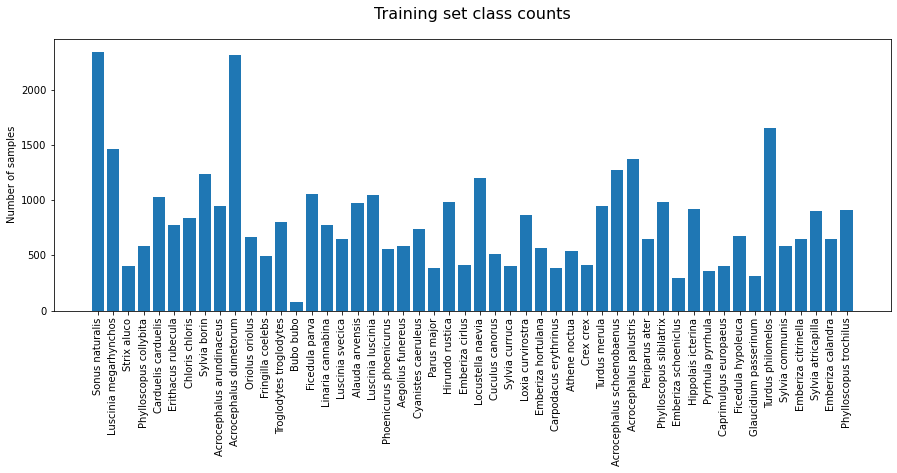

In [220]:
train_labels = [' '.join(
    (test_df[test_df.catg==c].ID.iloc[0]).split('_')[1:3]
) for c in test_df.catg.unique()]

train_plot = train_df.catg.value_counts()
plt.figure(figsize=(15,5))
plt.bar(x=train_plot.index, height=train_plot.values)
plt.xticks(np.arange(0,50,1), labels=train_labels, rotation=90)
plt.xlabel(None)
plt.ylabel('Number of samples')
plt.title('Training set class counts', fontdict={'size':16}, y=1.05)
plt.show()

### Augmentation of train samples
To prevent overfitting, random augmentation is performed on each sample.
#### A. Time shift
Each time a new signal sample is drawn, a random time shiift is applied, meaning sample is being randomly cut in half and two parts are swaped places.
#### B. Pitch shift
A random pitch shifting with variation of 3 half tones is applied to each train signal.
#### C. Adding noise
For each sample additional noise is added with multiplication factor of 0.4, choosing randomly from signal/noise split remains. Both signals are normalized before addition.
#### D. Combining more samples of same class
Additionally, to each sample another one (chosen randomly) of same class is added with random factor 0 to 0.5.

Final step: spectrogram normalization.

### Feature generation
Process of augmentation and feature generation is simultaneous with training. Samples are drawn as
signal chunks, randomly assigned second same-class pair and noise and preprocessed, so the neural
network can be fed with randomly processed data. Augmentation step is very important also because
the class distribution is strongly imbalanced.

#### Final features fed into neural network

From each signal sample after augmentation a spectrogram with ```window=1024``` and ```stride=259``` is generated. Stride is chosen in order to produce samples of length=256. Next step is to turn obtain spectrogram into mel scale spectrogram, which is more adequate in terms of proportions - takes into accound relationships between frequencies perceived by humans. Here, number of mel filterbanks is set as ```mels=128``` and additionally the spectrum of frequencies under consideration is narrowed to ```500Hz - 11000Hz```.

### Initializing Dataset generators

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout, BatchNormalization, Activation, Flatten, InputLayer
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import History, EarlyStopping, LearningRateScheduler
from tensorflow import keras as keras

config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [4]:
from soundmatrix.processing.machine_learning import AudioDataGenerator

params = {'batch_size': 64,
          'n_classes': num_classes,
          'n_channels': 1,
          'feature_params': {'f_type': 'mel_spec'}}

path = r'C:/birdify_samples/'

training_generator = AudioDataGenerator(train_df, noise_ids,
                                        over=True, augment=True,
                                        sample_dir=path + 'chunks_signal/',
                                        noise_dir=path + 'chunks_noise/',
                                        shuffle=True,
                                        **params)

validation_generator = AudioDataGenerator(validation_df, noise_ids,
                                          over=False, augment=False,
                                          sample_dir=path + 'chunks_signal/',
                                          noise_dir=None,
                                          shuffle=True,
                                          **params)
test_generator = AudioDataGenerator(test_df, noise_ids,
                                    over=False, augment=False,
                                    sample_dir=path + 'chunks_signal/',
                                    noise_dir=None,
                                    shuffle=False,
                                    **params)

input_shape, preview = training_generator.shape

train = training_generator.data_generator()
validate = validation_generator.data_generator()
test = test_generator.data_generator()

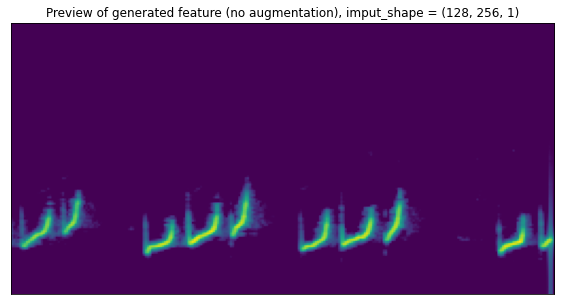

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.imshow(preview.reshape(input_shape[:-1]))
plt.title(f'Preview of generated feature (no augmentation), imput_shape = {input_shape}')
plt.xticks([])
plt.yticks([])
plt.show()

## 3. Modeling

### CNN architecture
Model architecture is inspired by [2]. This structure provides good learning capacity for task of categorization based on spectrogram features.

In [7]:
def set_model(set_padding = "same", act_f = "relu"):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Dropout(.2))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (5, 5), strides=(1, 2), padding = set_padding))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Activation(act_f))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (5, 5), strides=(1, 1), padding = set_padding))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Activation(act_f))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (5, 5), strides=(1,1), padding = set_padding))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Activation(act_f))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3,3), strides=(1, 1), padding = set_padding))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Activation(act_f))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(.4))
    model.add(Dense(1024, activation=act_f, use_bias=False))
    model.add(Dropout(.4))
    model.add(Dense(num_classes, activation="softmax"))
    return model

model = set_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 128, 256, 1)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 256, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       2

### Hyperparameters
First steps of hyperparametr optimization were performed on dataset containing only 5 most numerous species.
#### Optimizer
An SGD optimizer with Nesterov momentum of 0.9 is used.
#### Finding Learning Rate
For time efficiency reasons, finding optimal range for learning rate hyperparameter is performed using _Learning Rate Finder_ strategy [6].
This turned out to work pretty good with previous attempts on 5 species categorization.

The idea is to change exponentially learning rate with each step throughout small number of epochs (here - one epoch) to cover whole scape of values - from learning rate being way too low, to values exceeding optimum spectrum, where loss begins to diverge. As a result a function of learning rate hyperparameter against loss is obtained, and can be visuallised, giving a hint as to the reasonable range of the optimum.

In [17]:
class LRF(tf.keras.callbacks.Callback):
    def __init__(self) -> None:
        super().__init__()
        self.history = []
    
    def on_train_batch_end(self, batch, logs=None):
        lr = tf.keras.backend.get_value(
                self.model.optimizer.lr(self.model.optimizer.iterations)
            )
        logs = logs or {}
        loss = logs.get('loss')
        
        self.history.append((lr, loss))
    
lr_history = LRF()

In [18]:
lrf_model = set_model()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-10, decay_steps=1, decay_rate=1.037)
sgd = keras.optimizers.SGD(lr_schedule, momentum=0.9, nesterov=True)

lrf_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["categorical_accuracy",  tf.keras.metrics.Precision()])

lrf_model.fit(train, validation_data=validate, epochs=1, callbacks=[lr_history])

634/634 [==============================] - 2240s 4s/step - loss: 6.0452 - categorical_accuracy: 0.0283 - precision_3: 0.0347 - val_loss: 15.7478 - val_categorical_accuracy: 0.0230 - val_precision_3: 0.0230


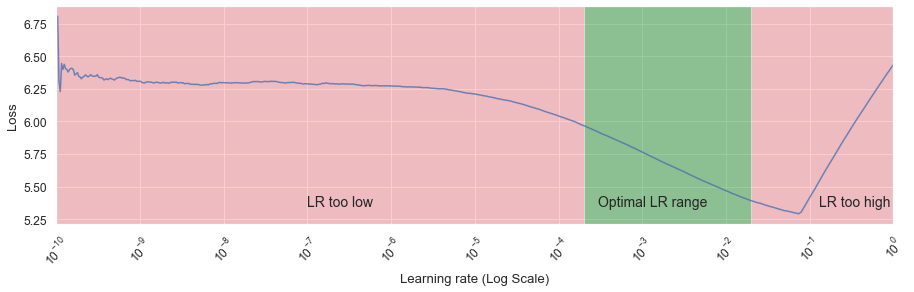

In [116]:
import numpy as np

lr_loss = np.array(lr_history.history)

y_loss = lr_loss[:,1]
x_l_rate = lr_loss[:,0]

plt.figure(figsize=(15,4))
plt.plot(x_l_rate, y_loss, alpha=.8)
plt.xlabel("Learning rate (Log Scale)")
plt.ylabel("Loss")
plt.xscale('log')
log_space = [1*10**(-n) for n in range(11,-1,-1)]
plt.xticks(ticks=log_space ,rotation=45)

plt.axvspan(1e-10, 2e-4, facecolor='red', alpha=0.2)
plt.axvspan(2e-4, 2e-2, facecolor='green', alpha=0.4)
plt.axvspan(2e-2, 1, facecolor='red', alpha=0.2)
plt.text(10e-8, 5.35, "LR too low", fontsize=14)
plt.text(3e-4, 5.35, "Optimal LR range",fontsize=14)
plt.text(1.3e-1, 5.35, "LR too high",fontsize=14)
plt.xlim(1e-10,1)

plt.show()

### Learning
Chosen ```learning_rate=0.05```

In [27]:
sgd = keras.optimizers.SGD(0.005, momentum=0.9, nesterov=True)

history = History()
model = set_model()
early_stopping = EarlyStopping(patience=5, monitor="val_loss", mode='min')

ModelCheck = tf.keras.callbacks.ModelCheckpoint('models/all_model_checkpoints.h5', monitor='val_loss', verbose=0,
                                                save_best_only=True, save_weights_only=True, mode='auto') 

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["categorical_accuracy", tf.keras.metrics.Precision()])

training_history = model.fit(train, validation_data=validate, epochs=50, callbacks=[history, early_stopping, ModelCheck])

Epoch 1/50
634/634 [==============================] - 2222s 3s/step - loss: 3.0084 - categorical_accuracy: 0.2485 - precision_4: 0.5172 - val_loss: 2.1109 - val_categorical_accuracy: 0.4650 - val_precision_4: 0.6402
Epoch 2/50
634/634 [==============================] - 2222s 4s/step - loss: 1.8787 - categorical_accuracy: 0.4865 - precision_4: 0.7045 - val_loss: 2.3123 - val_categorical_accuracy: 0.4799 - val_precision_4: 0.5915
Epoch 3/50
634/634 [==============================] - 2254s 4s/step - loss: 1.4944 - categorical_accuracy: 0.5916 - precision_4: 0.7642 - val_loss: 2.0505 - val_categorical_accuracy: 0.5346 - val_precision_4: 0.6384
Epoch 4/50
634/634 [==============================] - 2300s 4s/step - loss: 1.2890 - categorical_accuracy: 0.6428 - precision_4: 0.7945 - val_loss: 1.6118 - val_categorical_accuracy: 0.6148 - val_precision_4: 0.7195
Epoch 5/50
634/634 [==============================] - 2276s 4s/step - loss: 1.1415 - categorical_accuracy: 0.6848 - precision_4: 0.8197 

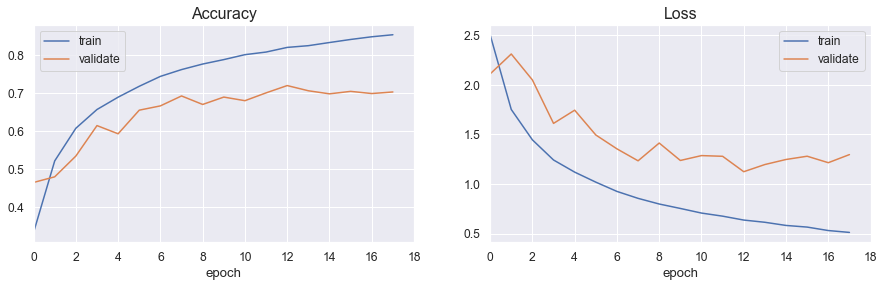

In [177]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
axs[0].plot(history.history['categorical_accuracy'], label='train')
axs[0].plot(history.history['val_categorical_accuracy'], label='validate')
axs[0].set_xlabel('epoch')
axs[0].set_xlim(0,18)
axs[0].legend()
axs[0].set_title('Accuracy', {'fontsize': 16})
axs[1].plot(history.history['loss'], label='train')
axs[1].plot(history.history['val_loss'], label='validate')
axs[1].set_title('Loss', {'fontsize': 16})
axs[1].set_xlabel('epoch')
axs[1].set_xlim(0,18)
axs[1].legend()
plt.show()

In [178]:
model.save('models\full_awesome_model')

INFO:tensorflow:Assets written to: models/full_awesome_model\assets


In [183]:
lo, acc, pr = model.evaluate(test)
print(f'Loss on test dataset: {np.round(lo, 3)}')
print(f'Accuracy on test dataset: {np.round(acc, 3)}')
print(f'Precision on test dataset: {np.round(pr, 3)}')

Loss on test dataset: 1.33
Accuracy on test dataset: 0.688
Precision on test dataset: 0.783


## 4. Results and discussion 

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
test_load = test.unbatch()
test_load = list(test_load.as_numpy_iterator())
X_test, y_test = [n[0] for n in test_load], [n[1] for n in test_load]
X_test = np.array(X_test)
y_pred = model.predict(X_test)

For the sake of readability, a generalized confusion matrix is presented below.

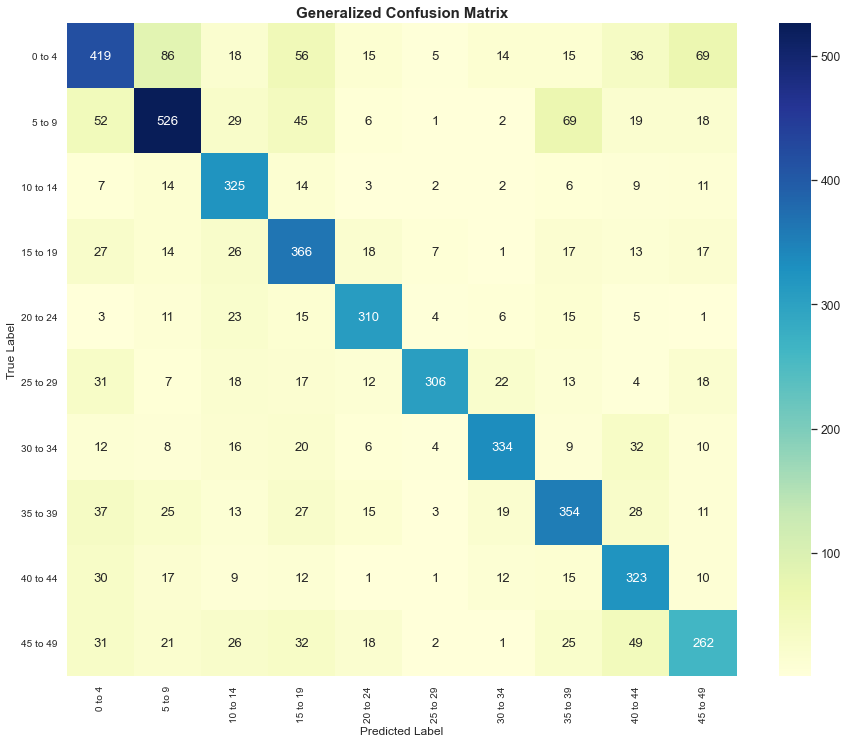

In [37]:
from soundmatrix.visuals import generalize_cfmatrix, plot_cfm
con_mat = confusion_matrix(np.argmax(y_test, axis=1),
                           np.argmax(y_pred, axis=1))
num_groups = 10
gen_cfmatrix = generalize_cfmatrix(con_mat, num_groups)

labels = [f'{n*5} to {n*5+4}' for n in range(num_groups)]
plot_cfm(gen_cfmatrix, labels, title="Generalized Confusion Matrix", size=(15, 12))

### Classification report

For most bird species, the accuracy and f1 metric exceed 0.70, giving the model a relatively good score.

In [214]:
import seaborn as sns
labels = [' '.join(
    (test_df[test_df.catg==c].ID.iloc[0]).split('_')[1:3],
)+' - class '+str(c) for c in test_df.catg.unique()]
report = pd.DataFrame(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=labels, output_dict=True)).transpose().round(2)
report.support = report.support.astype(int)
sorted_report = report.iloc[:-3].sort_values(by='f1-score', ascending=False).append(report.iloc[-3:])
# cm = sns.light_palette("blue", as_cmap=True)
sorted_report.style.background_gradient(subset=['precision', 'recall'], cmap='viridis_r').set_precision(2)

,precision,recall,f1-score,support
Aegolius funereus - class 20,0.91,1.00,0.95,74
Crex crex - class 32,0.98,0.89,0.93,53
Athene noctua - class 31,0.95,0.88,0.92,69
Glaucidium passerinum - class 43,0.97,0.82,0.89,40
Caprimulgus europaeus - class 41,0.83,0.94,0.88,51
Strix aluco - class 2,0.87,0.87,0.87,52
Locustella naevia - class 25,0.98,0.77,0.86,151
Carpodacus erythrinus - class 30,0.93,0.80,0.86,49
Ficedula parva - class 14,0.80,0.89,0.85,133
Carduelis carduelis - class 4,0.79,0.91,0.84,129


#### A closer look at misclassification for class with lowest f1
Here, despite 100% accuracy, most of the samples were misclassified.

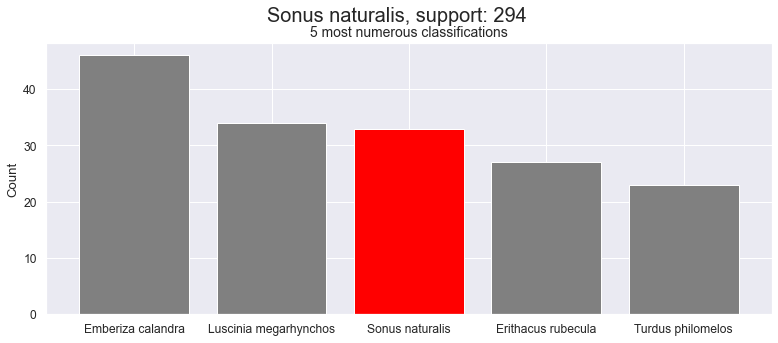

In [188]:
labels = [' '.join(
    (test_df[test_df.catg==c].ID.iloc[0]).split('_')[1:3],
) for c in test_df.catg.unique()]
sonus = np.vstack((np.array(labels)[con_mat[0].argsort()[::-1]], con_mat[0][con_mat[0].argsort()[::-1]]))
sonus_missclass = sonus[:,:5]
plt.figure(figsize=(13,5))
clrs = ['red' if 'Sonus naturalis' in x else 'grey' for x in sonus_missclass[0]]
x = sonus_missclass[0]
h = sonus_missclass[1].astype(int)
plt.bar(x, height=h, color=clrs)
plt.ylabel('Count')
plt.title(f'5 most numerous classifications', {'fontsize': 14})
plt.suptitle(f'Sonus naturalis, support: {sonus[1].astype(int).sum()}', fontsize=20)
plt.show()

All samples of species Aegolius funereus were classified correctly, scoring the best f1 of 0.95.\
Crex crex species has second best f1 score, below classification on test set, with singular classification fails.

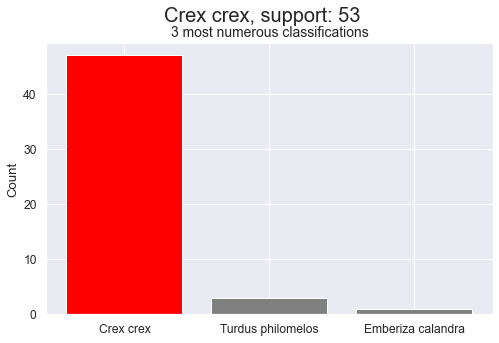

In [191]:
labels = [' '.join(
    (test_df[test_df.catg==c].ID.iloc[0]).split('_')[1:3],
) for c in test_df.catg.unique()]
sonus = np.vstack((np.array(labels)[con_mat[32].argsort()[::-1]], con_mat[32][con_mat[32].argsort()[::-1]]))
sonus_missclass = sonus[:,:3]
plt.figure(figsize=(8,5))
clrs = ['red' if 'Crex crex' in x else 'grey' for x in sonus_missclass[0]]
x = sonus_missclass[0]
h = sonus_missclass[1].astype(int)
plt.bar(x, height=h, color=clrs)
plt.ylabel('Count')
plt.title(f'3 most numerous classifications', {'fontsize': 14})
plt.suptitle(f'Crex crex, support: {sonus[1].astype(int).sum()}', fontsize=20)
plt.show()

## References

[1] Sprengel, E., Jaggi, M., Kilcher, Y., & Hofmann, T. (2016). Audio Based Bird Species Identification using Deep Learning Techniques. CLEF.\
[2] Kahl, S., Wilhelm-Stein, T., Hussein, H., Klinck, H., Kowerko, D., Ritter, M., & Eibl, M. (2017). Large-Scale Bird Sound Classification using Convolutional Neural Networks. CLEF.\
[3] Smith, L. N., (2017). Cyclical Learning Rates for Training Neural Networks. IEEE Winter Conference on Applications of Computer Vision.\
[4] Lasseck, M., (2013). Bird song classification in field recordings: winning solution for nips4b2013 competition. Proc. of int. symp. Neural Information Scaled for Bioacoustics.\
[5] Abreu e Lima, F., (2020). Bird songs from Europe (xeno-canto). https://www.kaggle.com/dsv/1029985 \
[6] https://www.jeremyjordan.me/nn-learning-rate/